# Лабораторная работа 8  
## Тактовая, частотная и фазовая рассинхронизации
Выполнила: Шаповалова Виктория, ИКТ-11М.  

В данной лабораторной работе собрана приемопередающая система, которая обладает частотной, фазовой и тактовой синхронизацией.

### 1. Импорт библиотек  
В данном разделе импортируются библиотеки, которые будут использоваться в ходе выполнения работы.

In [80]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import scipy
from scipy import signal
from scipy.signal import max_len_seq
from ModulationPy import PSKModem
from scipy.fftpack import fft, ifft, fftfreq, fftshift
import time
from scipy.signal import max_len_seq


### 2. Задание параметров  
В данном разделе задаются параметры, которые будут использованы в ходе выполнения работы.

In [81]:
data_len = 2**11 #длина информационной последовательности
order = 4 #порядок модуляции
mod_shift = np.pi/4 #поворот созвездия
offset = 2e3 #смещение по частоте
fs = 1e6 #частота дискретизации 
snr = 30 #отношение сигнал/шум
offset_phase = np.pi/6 #фазовый сдвиг
 
sps = 8
alpha = 0.35  

delay = 23 #задержка
N = delay*2 #порядок фильтра (формирование задержки)

num_tups = 141 #порядок фильтра (RRC)

### 3. Генерация случайного сигнала  
В данном разделе с помощью функции рандома генерируется информационный сигнал длины data_len для дальнейшей передачи.

In [82]:
data = []  
for i in range(data_len):
    data.append(random.randint(0, order-1)) 


### 4. PSK модуляция

В данном разделе определяется модуляция QPSK и применяется к сгенерированным ранее данным. На графиках представлены созвездие и временное представление модулированных данных.

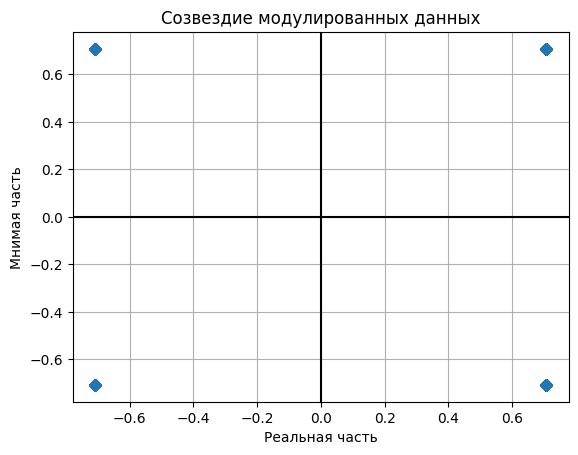

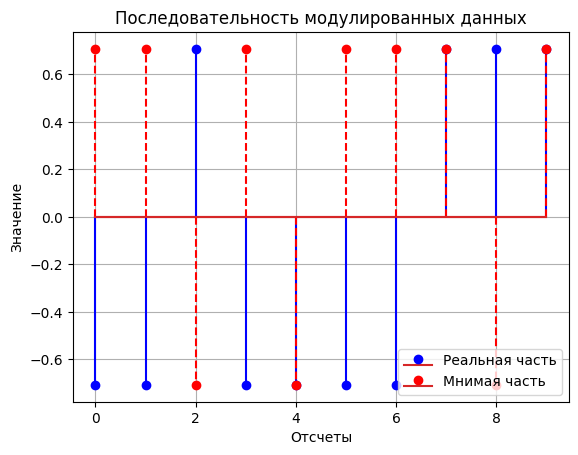

In [83]:
modem = PSKModem(order, mod_shift, 
                 bin_input=False,
                 soft_decision=False,
                 bin_output=False)

data_mod = modem.modulate(data) 

plt.figure()
plt.plot(np.real(data_mod),np.imag(data_mod), 'D')
plt.title('Созвездие модулированных данных')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.grid()

plt.figure()
plt.stem(np.real(data_mod[:10]), 'blue', label = 'Реальная часть')
plt.stem(np.imag(data_mod[:10]), 'r--',  label = 'Мнимая часть')
plt.title('Последовательность модулированных данных')
plt.xlabel("Отсчеты")
plt.ylabel("Значение")
plt.legend()
plt.grid()

### 5. Преамбула
В данном разделе к модулированным данным добавляется преамбула для дальнейшего обеспечения кадровой синхронизации. На графиках представлены автокорреляционная функция преамбулы, а также временное представление модулированных данных с преамбулой.

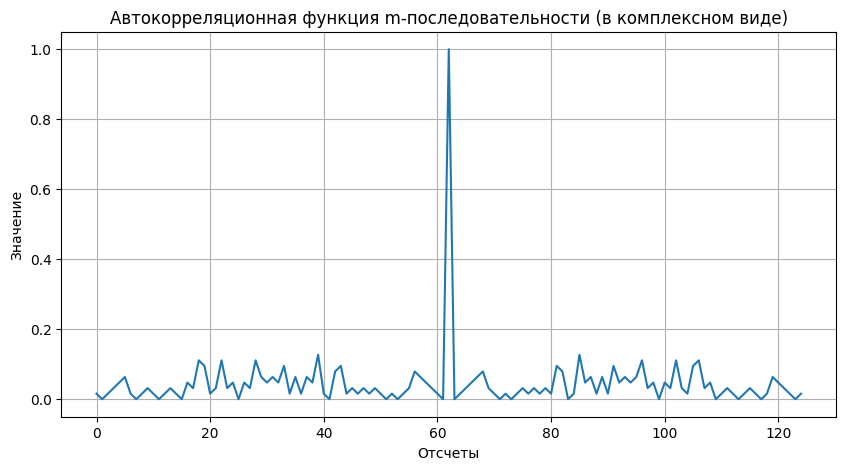

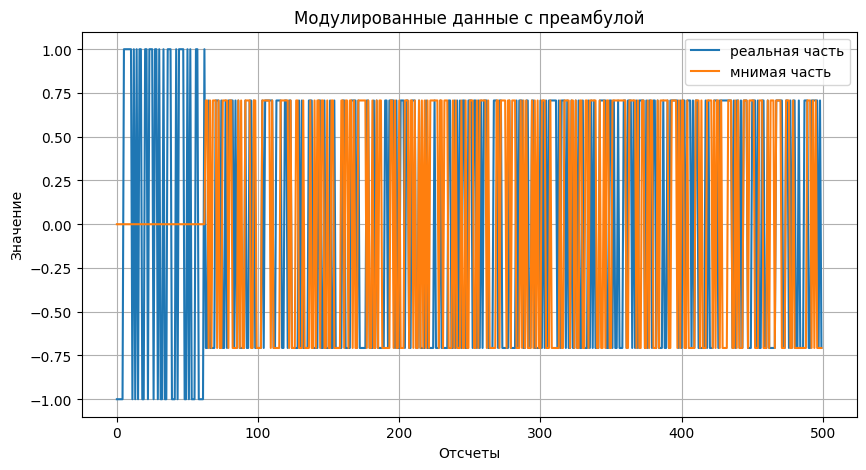

In [84]:
pream = max_len_seq(nbits=6, state=[0, 0, 0, 0, 0, 1])[0]*2-1
data_tx = np.hstack([pream, data_mod])

plt.figure(figsize=(10, 5))
plt.plot(np.abs(np.correlate(pream, pream, mode='full')/len(pream)))
plt.title('Автокорреляционная функция m-последовательности (в комплексном виде)')
plt.xlabel('Отсчеты')
plt.ylabel('Значение')
plt.grid()

plt.figure(figsize=(10, 5))
plt.plot(np.real(data_tx[:500]), label = 'реальная часть')
plt.plot(np.imag(data_tx[:500]), label = 'мнимая часть')
plt.title('Модулированные данные с преамбулой')
plt.xlabel('Отсчеты')
plt.ylabel('Значение')
plt.legend()
plt.grid()

### 6. Формирующий фильтр  
На данном этапе определяется функция формирующего фильтра. В качестве формирующего фильтра выбран фильтр корня из приподнятого косинуса. Перед его применением к данным применяется повышающая интерполяция.

In [85]:
def rrc_filt(N, alpha, Ts, Fs):
    T_delta = 1/float(Fs)
    sample_num = np.arange(N)
    h_rrc = np.zeros(N, dtype=float)

    for x in sample_num:
        t = (x-N/2)*T_delta
        if t == 0.0:
            h_rrc[x] = 1.0 - alpha + (4*alpha/np.pi)
        elif alpha != 0 and t == Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif alpha != 0 and t == -Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        else:
            h_rrc[x] = (np.sin(np.pi*t*(1-alpha)/Ts) +  \
                    4*alpha*(t/Ts)*np.cos(np.pi*t*(1+alpha)/Ts))/ \
                    (np.pi*t*(1-(4*alpha*t/Ts)*(4*alpha*t/Ts))/Ts)

    return h_rrc

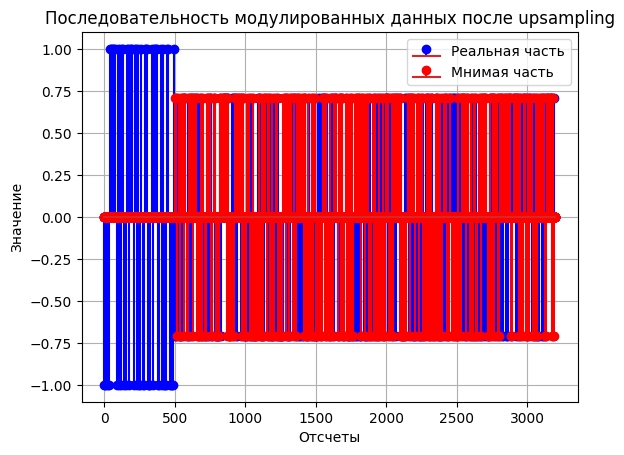

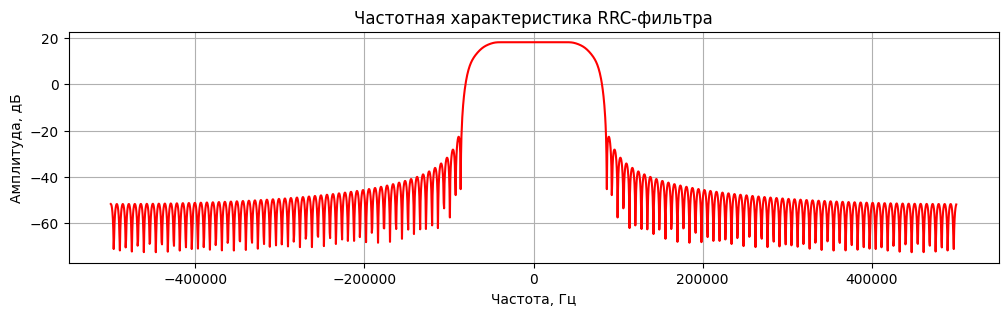

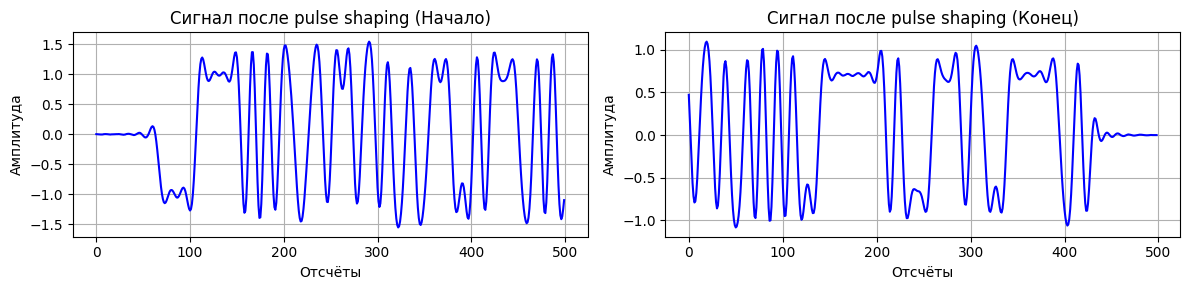

In [86]:
upsampled = np.zeros(len(data_tx) * sps, dtype=complex)
upsampled[0::sps] = data_tx  

plt.figure()
plt.stem(np.real(upsampled[:sps*400]), 'blue', label = 'Реальная часть')
plt.stem(np.imag(upsampled[:sps*400]), 'red',  label = 'Мнимая часть')
plt.title('Последовательность модулированных данных после upsampling')
plt.xlabel("Отсчеты")
plt.ylabel("Значение")
plt.legend()
plt.grid()


h_rrc = rrc_filt(num_tups, alpha, sps/fs, fs)
tx = np.convolve(upsampled, h_rrc)

H = fftshift(fft(h_rrc, 2048))
f = np.linspace(-fs/2, fs/2, len(H))

plt.figure(figsize=(12, 3))
plt.plot(f, 20*np.log10(np.abs(H)), 'r-')
plt.title("Частотная характеристика RRC-фильтра")
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда, дБ")
plt.grid()


plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(tx[0:500], 'b-')
plt.title("Сигнал после pulse shaping (Начало)")
plt.xlabel("Отсчёты")
plt.ylabel("Амплитуда")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(tx[-500:-1], 'b-')
plt.title("Сигнал после pulse shaping (Конец)")
plt.xlabel("Отсчёты")
plt.ylabel("Амплитуда")
plt.grid()
plt.tight_layout()


### 7. Частотный сдвиг  
В данном разделе к модулированным данным применяется частотный сдвиг. На графиках представлены созвездия до и после частотного сдвига.

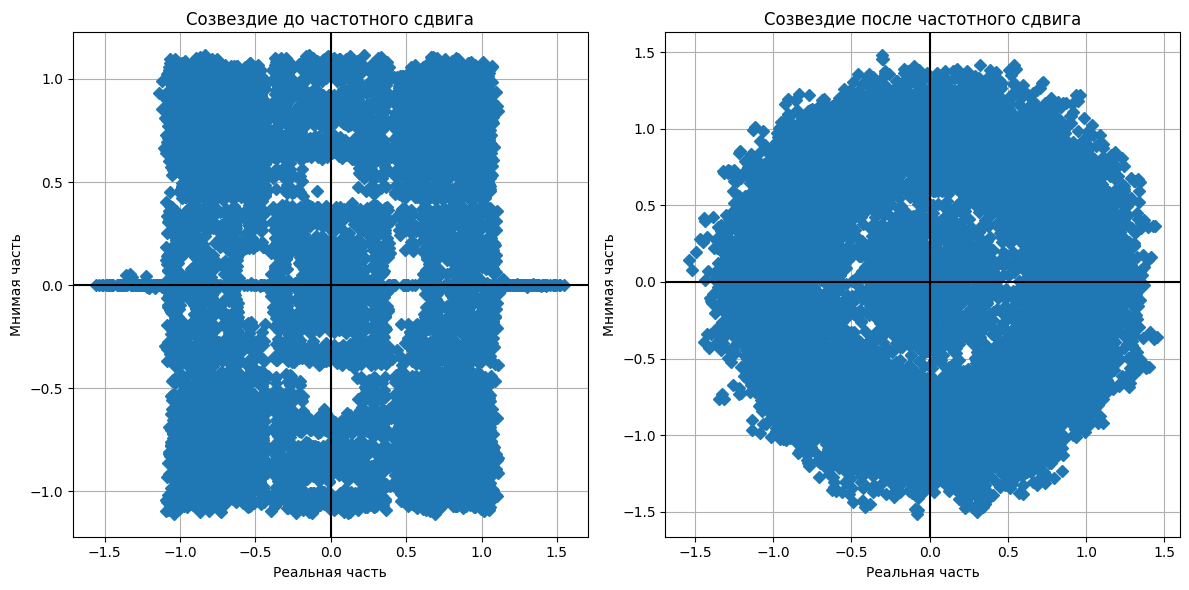

In [87]:
def freq_offset(data, offset, fs):
    t = np.arange(0, len(data))/fs 
    data = data * np.exp(1j*2*np.pi*offset*t) 
    return data

data_mod_offset = freq_offset(tx, offset, fs)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(np.real(data_mod_offset),np.imag(data_mod_offset), 'D')
plt.title('Созвездие после частотного сдвига')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.grid()

plt.subplot(1, 2, 1)
plt.plot(np.real(tx),np.imag(tx), 'D')
plt.title('Созвездие до частотного сдвига')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.grid()
plt.tight_layout()

### 8. Фазовый сдвиг
В данном разделе добавляется фазовый сдвиг.

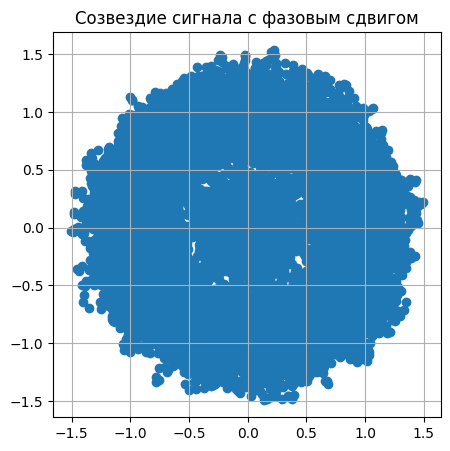

In [88]:
def phase_offset_func(data, phase):
    data = data * np.exp(1j*phase) 
    return data

data_mod_phaseof = phase_offset_func(data_mod_offset, offset_phase)

plt.figure(figsize=(5, 5))
plt.scatter(np.real(data_mod_phaseof), np.imag(data_mod_phaseof))
plt.title("Созвездие сигнала с фазовым сдвигом")
plt.grid()


### 9. Добавление шума 
На следующем шаге производится генерация и добавление АБГШ к данным с частотным и фазовым сдвигом.

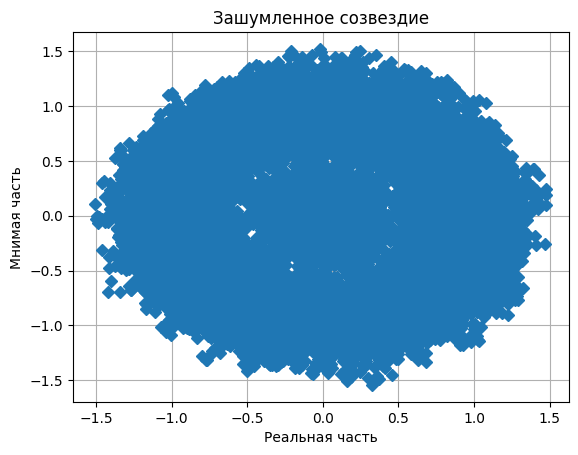

In [89]:
def awgn(signal, snr):
    sig_power = np.mean(np.abs(signal)**2) # calculate signal power
    sig_power_db = 10* np.log10(sig_power) # convert to dB

    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(signal)) + \
                                            np.random.randn(len(signal))*1j)

    return complex_noise

awgn_noise = awgn(data_mod_phaseof, snr)
tx = data_mod_phaseof + awgn_noise

plt.figure()
plt.plot(tx.real, tx.imag, 'D')
plt.title('Зашумленное созвездие')
plt.ylabel("Мнимая часть")
plt.xlabel("Реальная часть")
plt.grid()

### 10. Задержка
На этом шаге вносится задержка во времени к передаваемым данным.

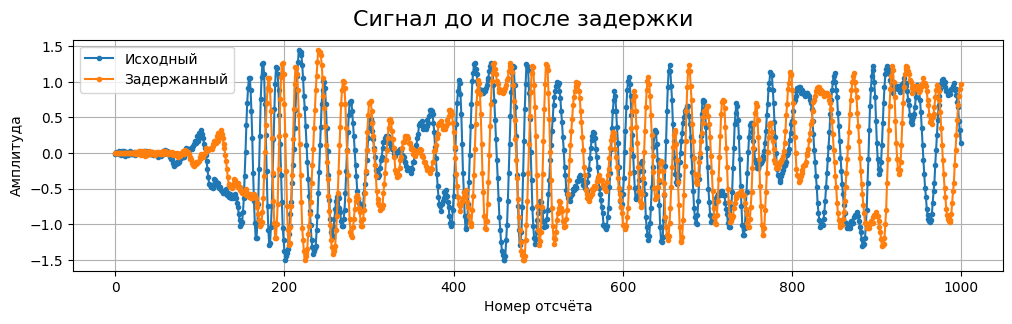

Задержка равна 23 отсчетам


In [90]:
n = np.arange(-N//2, N//2) # ...-3,-2,-1,0,1,2,3...
h = np.sinc(n)
h *= np.hamming(N) # использование окна Хэмминга для фильтра
h /= np.sum(h) # нормализация, чтобы получить единичный коэффициент усиления и не изменять амплитуду/мощность

fig, ax = plt.subplots(1,figsize=(12,3))
fig.suptitle("Сигнал до и после задержки", fontsize=16)
plt.plot(np.real(tx[:1000]), '.-', label = 'Исходный')

tx_shift = np.convolve(tx, h) # применение фильтра

plt.plot(np.real(tx_shift[:1000]), '.-', label = 'Задержанный')
ax.legend()
plt.grid()
plt.xlabel("Номер отсчёта")
plt.ylabel("Амплитуда")
plt.show()

print(f'Задержка равна {delay} отсчетам')

### 11. Согласованный фильтр  
Далее выполнена приемная часть. На приемной стороне установлен согласованный фильтр корня из приподнятого косинуса

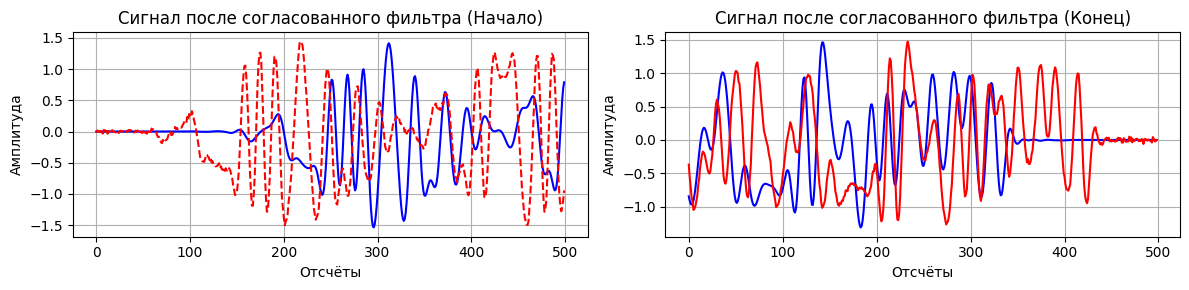

In [91]:
rx_ = np.convolve(tx_shift, h_rrc)/sps

# Визуализация временной области
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(rx_[0:500], 'b-')
plt.plot(tx[0:500], 'r--', label = 'после формирующего фильтра')
plt.title("Сигнал после согласованного фильтра (Начало)")
plt.xlabel("Отсчёты")
plt.ylabel("Амплитуда")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(rx_[-500:-1], 'b-')
plt.plot(tx[-500:-1], 'r', label = 'после формирующего фильтра')
plt.title("Сигнал после согласованного фильтра (Конец)")
plt.xlabel("Отсчёты")
plt.ylabel("Амплитуда")
plt.grid()
plt.tight_layout()

### 12. Тактовая синхронизация  
На данном шаге выполнена тактовая синхронизация по схеме Мюллера-Мюллера для компенсации задержки. В результате выполнения тактовой синхронизации отсчеты берутся в правильные моменты времени, однако по созвездию видно, что присутствует частотный сдвиг.

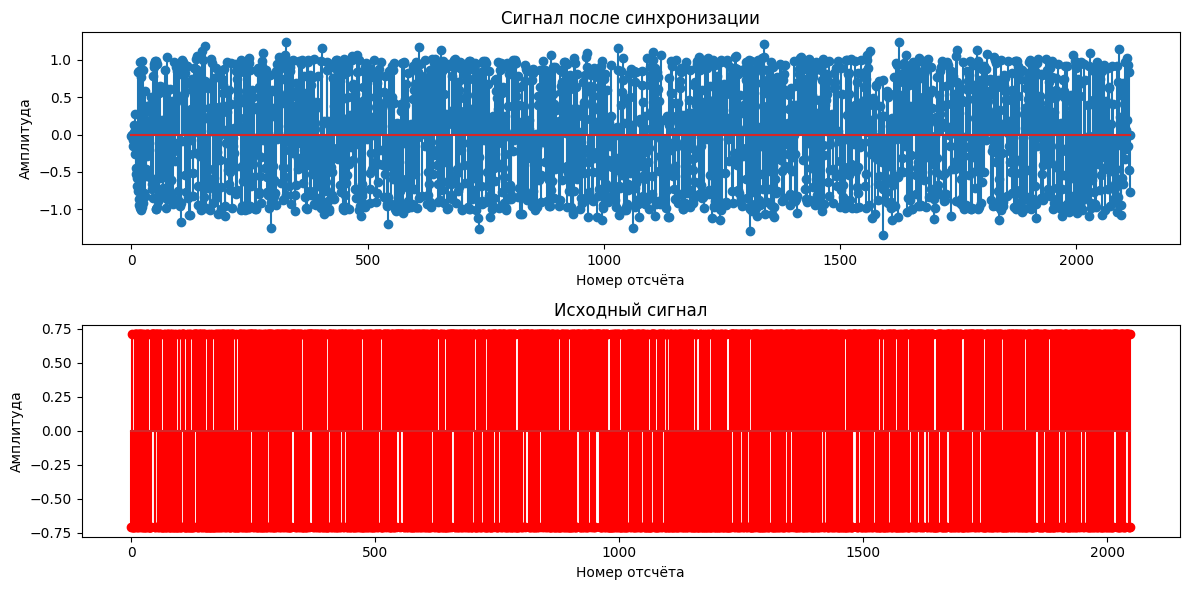

Text(0, 0.5, 'Мнимая часть')

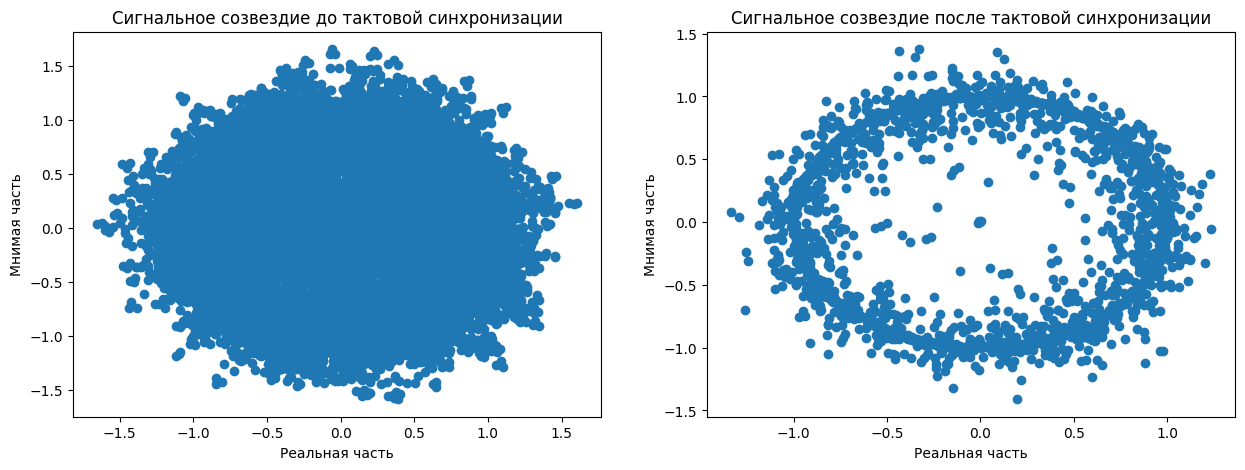

In [92]:

rx = rx_[(num_tups-1):-(num_tups-1)]
def syncMM(rx, sps):
    mu = 0 # initial estimate of phase of sample
    out = np.zeros(len(rx) + 10, dtype=np.complex64)
    out_rail = np.zeros(len(rx) + 10, dtype=np.complex64) # stores values, each iteration we need the previous 2 values plus current value
    i_in = 0 # input samples index
    i_out = 2 # output index (let first two outputs be 0)
    while i_out < len(rx) and i_in + 16 < len(rx):
        out[i_out] = rx[i_in] # grab what we think is the "best" sample
        out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
        x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
        y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
        mm_val = np.real(y - x)
        mu += sps + 0.35*mm_val
        i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
        mu = mu - np.floor(mu) # remove the integer part of mu
        i_out += 1 # increment output index
    out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)
    return(out)

rx_time_sync = syncMM(rx, sps)

fig, ((ax1, ax2)) = plt.subplots(2,1, figsize = (12,6))

ax1.title.set_text('Сигнал после синхронизации')
ax1.stem(rx_time_sync, '.-')
ax1.set_xlabel("Номер отсчёта")
ax1.set_ylabel("Амплитуда")


ax2.title.set_text('Исходный сигнал')
ax2.stem(data_mod, 'r')
ax2.set_xlabel("Номер отсчёта")
ax2.set_ylabel("Амплитуда")

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.scatter(np.real(rx_time_sync), np.imag(rx_time_sync))
plt.title('Сигнальное созвездие после тактовой синхронизации')
plt.xlabel('Реальная часть')
plt.ylabel('Мнимая часть')

plt.subplot(1, 2, 1)
plt.scatter(np.real(rx), np.imag(rx))
plt.title('Сигнальное созвездие до тактовой синхронизации')
plt.xlabel('Реальная часть')
plt.ylabel('Мнимая часть')

### 13. Частотная синхронизация (Грубая)
Выполняется по схеме аналогичной **M-power**. В результате выполнения грубой частотной синхронизации практически полностью исчезает частотный сдвиг, однако остается незначительный поворот созвездия, полученный фазовым и небольшим частотным сдвигом.

Оцененное значение смещения частоты 1995.0 Гц
Заданное значение смещения частоты 2000.0 Гц
Разница 5.0 Гц


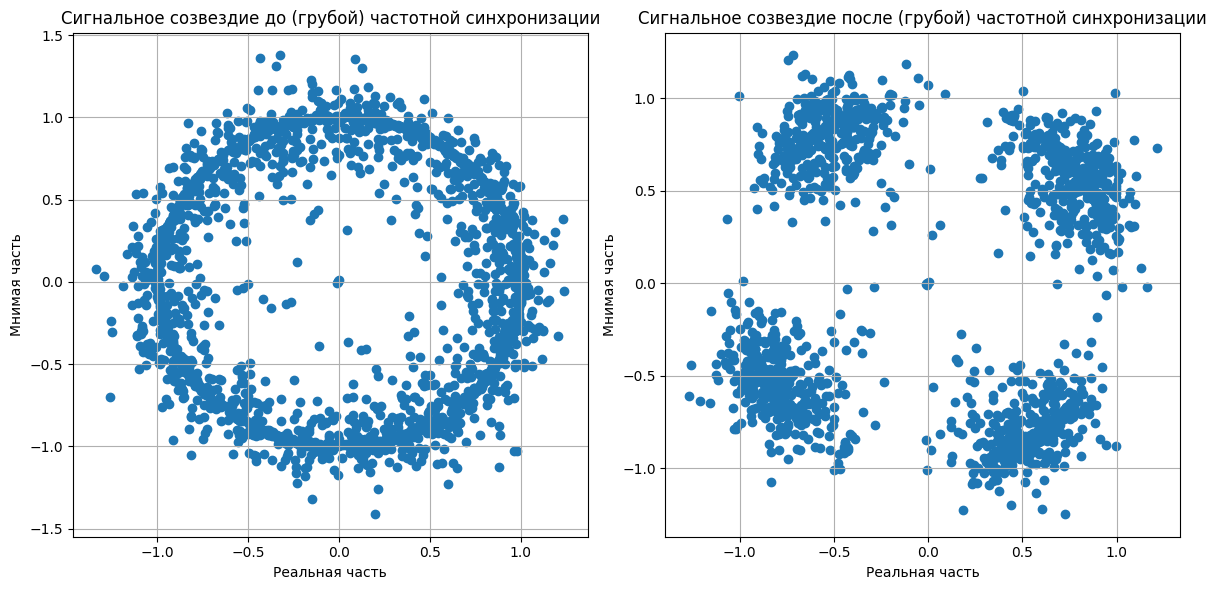

In [93]:
def freq_estimation(rx, sps, M):
    samples_qpsk = rx**M
    psd = np.fft.fftshift(np.abs(np.fft.fft(samples_qpsk)))
    f = np.linspace(-fs/(sps*2.0), fs/(2.0*sps), len(psd))
    max_freq = f[np.argmax(psd)]
    
    return max_freq//M

freq_offset_estimation = freq_estimation(rx_time_sync, sps, 4)
print(f'Оцененное значение смещения частоты {freq_offset_estimation} Гц')
print(f'Заданное значение смещения частоты {offset} Гц')
print(f'Разница {np.abs(offset - freq_offset_estimation)} Гц')


rx_freq_sync = freq_offset(rx_time_sync, -1*freq_offset_estimation, fs/sps)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Сигнальное созвездие до (грубой) частотной синхронизации')
plt.xlabel('Реальная часть')
plt.ylabel('Мнимая часть')
plt.scatter(np.real(rx_time_sync), np.imag(rx_time_sync))
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Сигнальное созвездие после (грубой) частотной синхронизации')
plt.xlabel('Реальная часть')
plt.ylabel('Мнимая часть')
plt.scatter(np.real(rx_freq_sync), np.imag(rx_freq_sync))
plt.grid()
plt.tight_layout()

### 14. Точная частотная (и фазовая) синхронизация
В данной разделе выполняются точная частотная и фазовая синхронизации с помощью петли Костаса для QPSK модуляции.

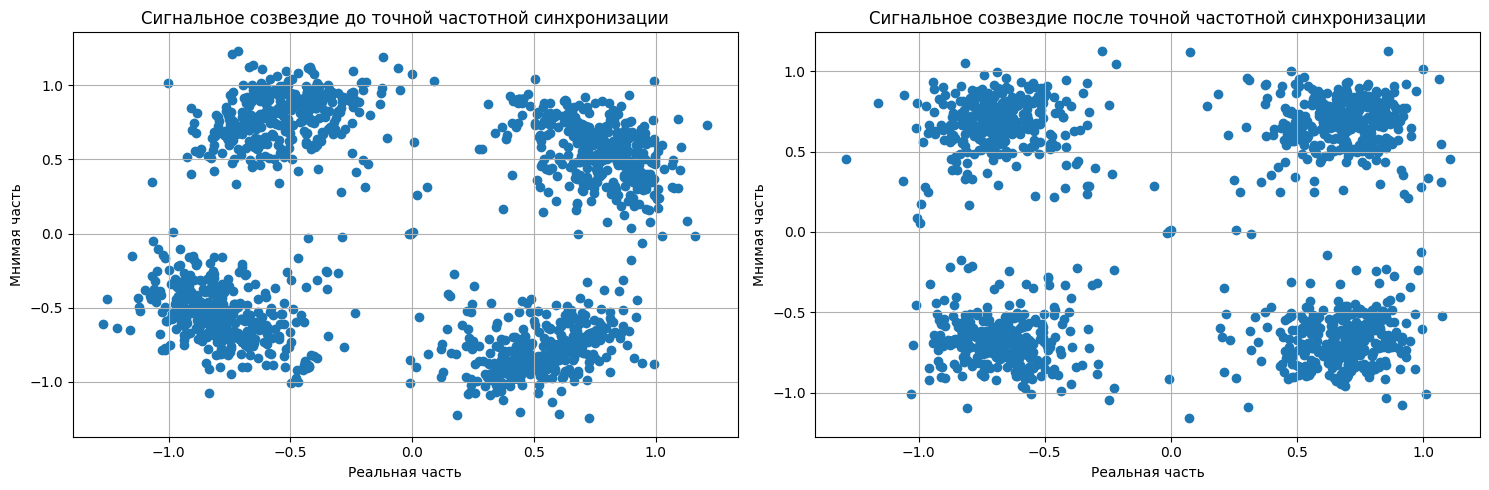

In [94]:
def phase_detector_QPSK(sample):
    point = np.arange(0, 4)
    ref_point = modem.modulate(point)
    distance = np.abs(sample - ref_point)
    ind_min = np.argmin(distance)
    error_angle = np.angle(sample*np.conj(ref_point[ind_min])) 
    return error_angle

def Costas_Loop(tx, alpha, beta):
    N = len(tx)
    phase = 0
    freq = 0
    
    out = np.zeros(N, dtype=np.complex64)

    for i in range(N):
        out[i] = tx[i] * np.exp(-1j*phase) 
        error = phase_detector_QPSK(out[i]) 

        freq += (beta * error)
        phase += freq + (alpha * error)

        while phase >= 2*np.pi:
            phase -= 2*np.pi
        while phase < 0:
            phase += 2*np.pi
        
    return out


sync_data = Costas_Loop(rx_freq_sync, alpha = 0.05, beta = 0.001)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Сигнальное созвездие до точной частотной синхронизации')
plt.xlabel('Реальная часть')
plt.ylabel('Мнимая часть')
plt.scatter(np.real(rx_freq_sync), np.imag(rx_freq_sync))
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Сигнальное созвездие после точной частотной синхронизации')
plt.xlabel('Реальная часть')
plt.ylabel('Мнимая часть')
plt.scatter(np.real(sync_data[:]), np.imag(sync_data[:]))
plt.grid()
plt.tight_layout()   



### 15. Кадровая синхронизация  
С помощью кадровой синхронизации выполняется определение начала информационных данных, что позволяет убрать временной сдвиг.

Номер отсчета, с которого начинаются QPSK модлированные символы - 66
Номер отсчета, с которого начинается преамбула - 3


Text(0, 0.5, 'Значение')

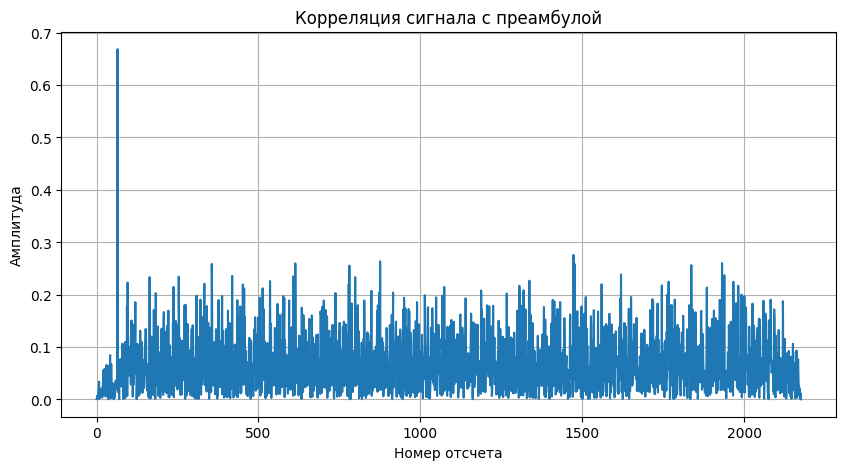

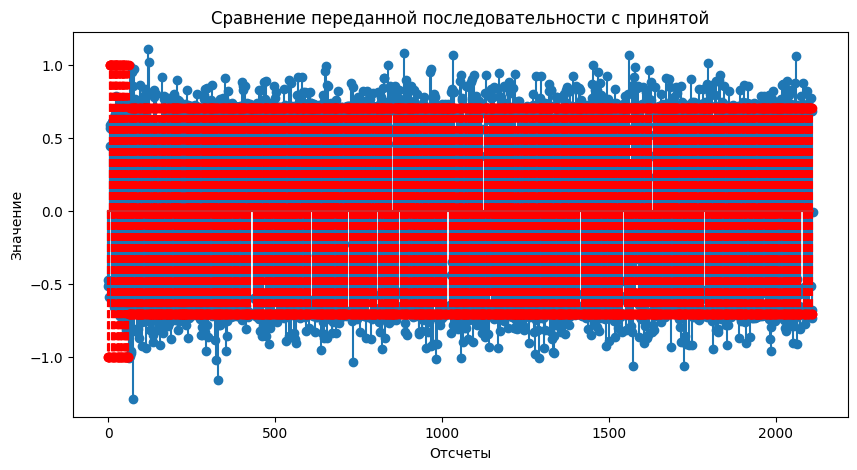

In [95]:
correlation = np.abs(np.correlate(np.real(sync_data), np.real(pream), mode='full')/len(pream))

position_correlation_max = np.argmax(correlation)
position_start = position_correlation_max + 1 - len(pream)
print(f'Номер отсчета, с которого начинаются QPSK модлированные символы - {position_correlation_max + 1}')
print(f'Номер отсчета, с которого начинается преамбула - {position_start}')

plt.figure(figsize=(10, 5))
plt.plot(correlation)
plt.title('Корреляция сигнала с преамбулой')
plt.xlabel('Номер отсчета')
plt.ylabel('Амплитуда')
plt.grid()

plt.figure(figsize=(10, 5))
plt.stem(np.real(sync_data[position_start:]))
plt.stem(np.real(data_tx), '--r')
plt.title('Сравнение переданной последовательности с принятой')
plt.xlabel('Отсчеты')
plt.ylabel('Значение')

### 16. Демодуляция  
На данном шаге выполняется демодуляция данных.

Число битовых ошибок в демодулированной последовательности: 3


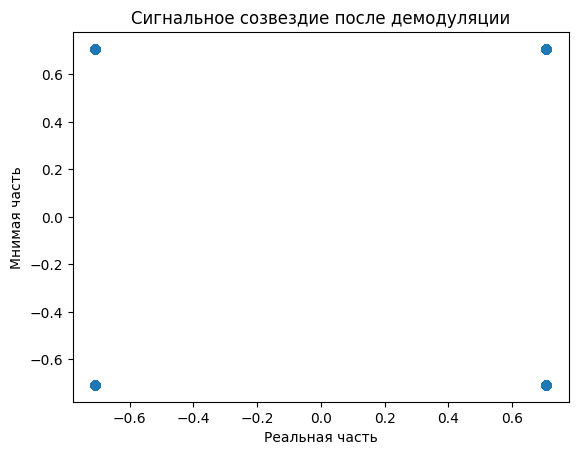

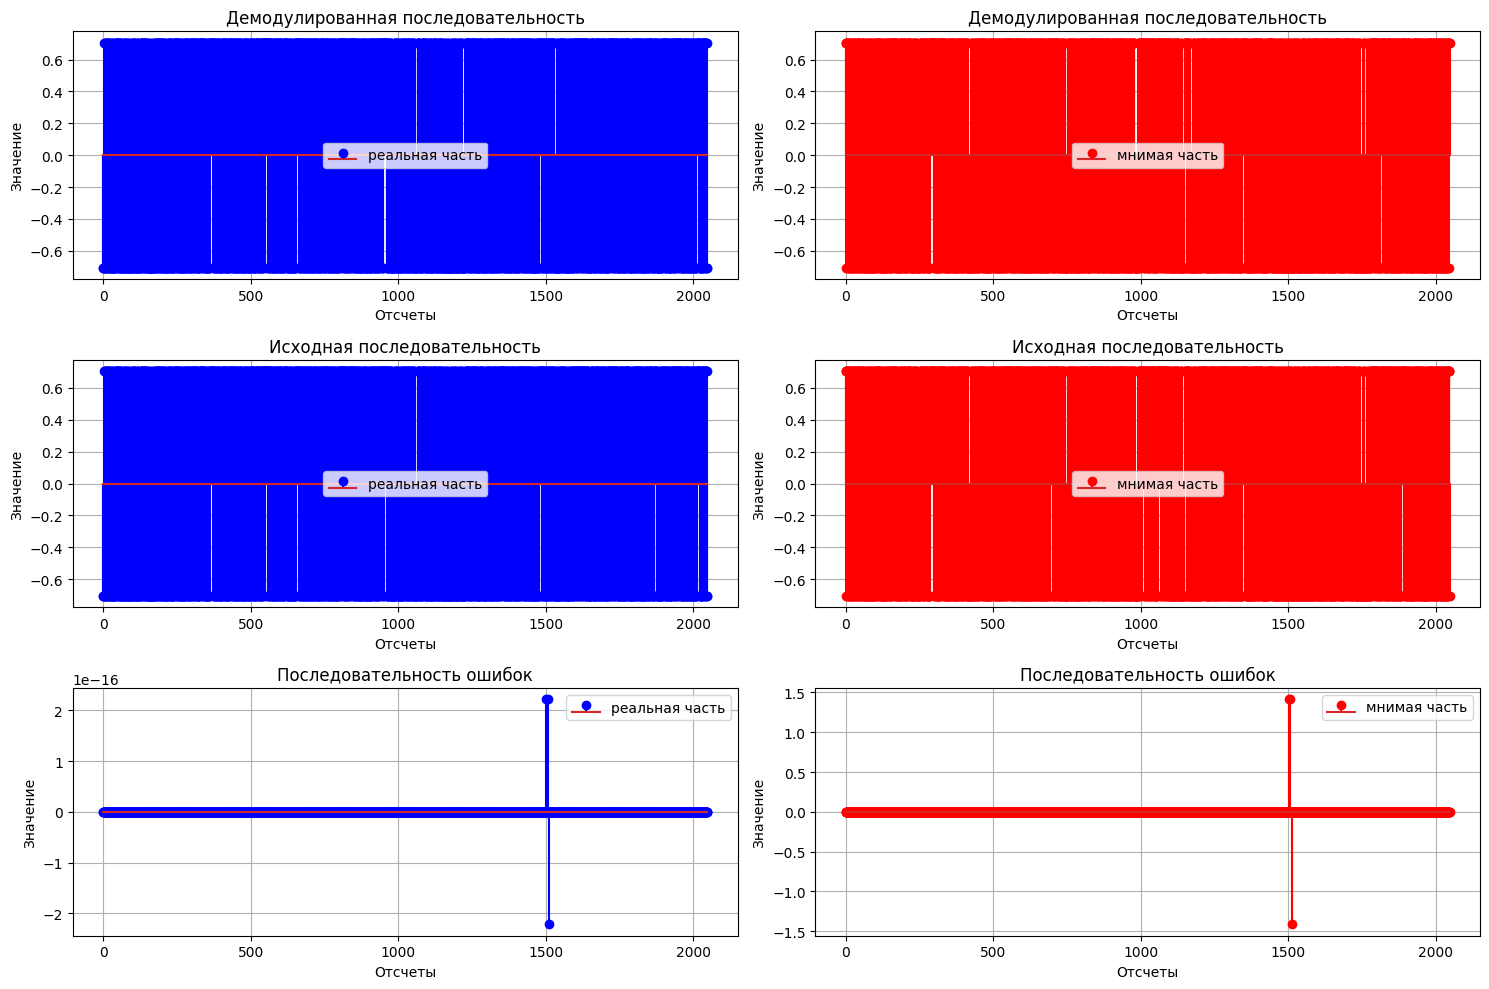

In [96]:
def qpsk_demod(signal_input):
    result = np.zeros((len(signal_input)), dtype=complex)
    point = np.arange(0, 4)
    ref_point = np.exp(1j*(np.pi/2.*point + np.pi/4))
    for i in np.arange(0, len(signal_input)):
        distance = np.abs(signal_input[i] - ref_point)
        ind_min = np.argmin(distance)
        result[i] = ref_point[ind_min]
    return result
    
hard_decisions = qpsk_demod(sync_data[position_correlation_max + 1:])
size_min = np.minimum(len(hard_decisions), len(data_mod))
print(f'Число битовых ошибок в демодулированной последовательности: {np.sum(hard_decisions[:size_min] != data_mod[:size_min])}')

plt.figure()
plt.scatter(np.real(hard_decisions), np.imag(hard_decisions))
plt.title('Сигнальное созвездие после демодуляции')
plt.xlabel('Реальная часть')
plt.ylabel('Мнимая часть')

plt.figure(figsize=(15, 10))
plt.subplot(3, 2, 1)
plt.title('Демодулированная последовательность')
plt.stem(np.real(hard_decisions), '-b', label='реальная часть')
plt.xlabel("Отсчеты")
plt.ylabel("Значение")
plt.legend()
plt.grid()

plt.subplot(3, 2, 2)
plt.title('Демодулированная последовательность')
plt.stem(np.imag(hard_decisions), '-r', label='мнимая часть')
plt.xlabel("Отсчеты")
plt.ylabel("Значение")
plt.legend()
plt.grid()

plt.subplot(3, 2, 3)
plt.title('Исходная последовательность')
plt.stem(np.real(data_mod), '-b', label='реальная часть')
plt.xlabel("Отсчеты")
plt.ylabel("Значение")
plt.legend()
plt.grid()

plt.subplot(3, 2, 4)
plt.title('Исходная последовательность')
plt.stem(np.imag(data_mod), '-r', label='мнимая часть')
plt.xlabel("Отсчеты")
plt.ylabel("Значение")
plt.legend()
plt.grid()

plt.subplot(3, 2, 5)
plt.title('Последовательность ошибок')
plt.stem(np.real(data_mod[:size_min]) - np.real(hard_decisions[:size_min]), '-b', label='реальная часть')
plt.xlabel("Отсчеты")
plt.ylabel("Значение")
plt.legend()
plt.grid()

plt.subplot(3, 2, 6)
plt.title('Последовательность ошибок')
plt.stem(np.imag(data_mod[:size_min]) - np.imag(hard_decisions[:size_min]), '-r', label='мнимая часть')
plt.xlabel("Отсчеты")
plt.ylabel("Значение")
plt.legend()
plt.grid()

plt.tight_layout()

### 17. Зависимость от шума  
Готовая система была исследована на зависимость от влияния АБГШ. Для оценки результатов построен график зависимости числа ошибок в принятой последовательности от отношения сигнал/шум. График показывает, что с увеличением отношения сигнал/шум число ошибок уменьшается. Однако в результатах может присутствовать выбросы, которые связаны со случайной некорректной работой одной из синхронизаций.

In [97]:
def test_awgn(snr_range, freq_offset_value, phase_offset_value, delay_value):
    bit_errors = np.zeros_like(snr_range)
    for iter_snr, snr in enumerate(snr_range):
        data = []  
        for i in range(data_len):
            data.append(random.randint(0, order-1)) 

        data_mod = modem.modulate(data) 
        data_tx = np.hstack([pream, data_mod])
        upsampled = np.zeros(len(data_tx) * sps, dtype=complex)
        upsampled[0::sps] = data_tx 
        
        tx = np.convolve(upsampled, h_rrc)
        data_mod_offset = freq_offset(tx, freq_offset_value, fs)
        data_mod_phaseof = phase_offset_func(data_mod_offset, phase_offset_value)
        awgn_noise = awgn(data_mod_phaseof, snr)
        tx = data_mod_phaseof + awgn_noise
        
        N = delay_value*2
        n = np.arange(-N//2, N//2)
        h = np.sinc(n)
        h *= np.hamming(N) 
        h /= np.sum(h) 

        tx_shift = np.convolve(tx, h) 
        rx_ = np.convolve(tx_shift, h_rrc)/sps
        
        rx = rx_[(num_tups-1):-(num_tups-1)]
        rx_time_sync = syncMM(rx, sps)
        
        freq_offset_estimation = freq_estimation(rx_time_sync, sps, 4)
        rx_freq_sync = freq_offset(rx_time_sync, -1*freq_offset_estimation, fs/sps)

        sync_data = Costas_Loop(rx_freq_sync, alpha = 0.05, beta = 0.001)
        
        correlation = np.abs(np.correlate(np.real(sync_data), np.real(pream), mode='full')/len(pream))
        position_correlation_max = np.argmax(correlation)
        position_start = position_correlation_max + 1 - len(pream)
        
        hard_decisions = qpsk_demod(sync_data[position_correlation_max + 1:])
        size_min = np.minimum(len(hard_decisions), len(data_mod))
        bit_errors[iter_snr] = np.sum(hard_decisions[:size_min] != data_mod[:size_min])
    
    return bit_errors

snr_range = np.arange(-4, 20, 2)
freq_offset_value = 2e3
phase_offset_value = np.pi/6
delay_value = 23

bit_errors_awgn =  test_awgn(snr_range, freq_offset_value, phase_offset_value, delay_value)

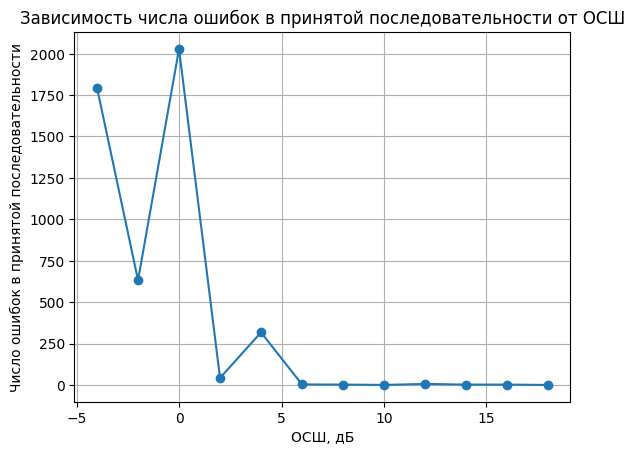

In [98]:
plt.figure()
plt.plot(snr_range, bit_errors_awgn, '-o')
plt.title('Зависимость числа ошибок в принятой последовательности от ОСШ')
plt.ylabel('Число ошибок в принятой последовательности')
plt.xlabel('OCШ, дБ')
plt.grid()

### 18. Зависимость от фазового сдвига  
Готовая система была исследована на зависимость от фазового сдвига. В качестве результатов построен график зависимости числа ошибок от величины фазового смещения. При повороте более чем на 45 градусов, петля Костаса доворачивает созвездие в неправильном направлении, что влечет за собой неверную демодуляцию. 

In [99]:
def test_phase(snr, freq_offset_value, phase_range, delay_value):
    bit_errors = np.zeros_like(phase_range)
    for iter_phase, phase in enumerate(phase_range):
        data = []  
        for i in range(data_len):
            data.append(random.randint(0, order-1)) 

        data_mod = modem.modulate(data) 
        data_tx = np.hstack([pream, data_mod])
        upsampled = np.zeros(len(data_tx) * sps, dtype=complex)
        upsampled[0::sps] = data_tx 
        
        tx = np.convolve(upsampled, h_rrc)
        data_mod_offset = freq_offset(tx, freq_offset_value, fs)
        data_mod_phaseof = phase_offset_func(data_mod_offset, phase)
        awgn_noise = awgn(data_mod_phaseof, snr)
        tx = data_mod_phaseof + awgn_noise
        
        N = delay_value*2
        n = np.arange(-N//2, N//2)
        h = np.sinc(n)
        h *= np.hamming(N) 
        h /= np.sum(h) 

        tx_shift = np.convolve(tx, h) 
        rx_ = np.convolve(tx_shift, h_rrc)/sps
        
        rx = rx_[(num_tups-1):-(num_tups-1)]
        rx_time_sync = syncMM(rx, sps)
        
        freq_offset_estimation = freq_estimation(rx_time_sync, sps, 4)
        rx_freq_sync = freq_offset(rx_time_sync, -1*freq_offset_estimation, fs/sps)

        sync_data = Costas_Loop(rx_freq_sync, alpha = 0.05, beta = 0.001)
        
        correlation = np.abs(np.correlate(np.real(sync_data), np.real(pream), mode='full')/len(pream))
        position_correlation_max = np.argmax(correlation)
        position_start = position_correlation_max + 1 - len(pream)
        
        hard_decisions = qpsk_demod(sync_data[position_correlation_max + 1:])
        size_min = np.minimum(len(hard_decisions), len(data_mod))
        bit_errors[iter_phase] = np.sum(hard_decisions[:size_min] != data_mod[:size_min])
    
    return bit_errors

snr = 30
freq_offset_value = 2e3
phase_offset_range = np.linspace(0, np.pi, 10) 
delay_value = 23

bit_errors_phase =  test_phase(snr, freq_offset_value, phase_offset_range, delay_value)

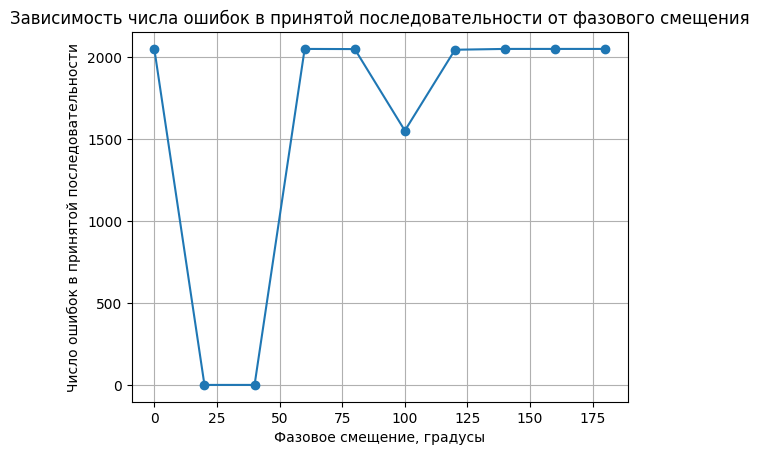

In [100]:
plt.figure()
plt.plot(phase_offset_range*180/np.pi, bit_errors_phase, '-o')
plt.title('Зависимость числа ошибок в принятой последовательности от фазового смещения')
plt.ylabel('Число ошибок в принятой последовательности')
plt.xlabel('Фазовое смещение, градусы')
plt.grid()

### 19. Зависимость от частотного сдвига  
Готовая система была исследована на зависимость от частотного сдвига. В качестве результатов построен график зависимости числа ошибок от величины частотного смещения. Разработанная система работает корректно только в диапазоне частотных смещений от 2000 до 3500 Гц.

In [101]:
def test_freq(snr, freq_offset_range, phase_offset_value, delay_value):
    bit_errors = np.zeros_like(freq_offset_range)
    for iter_freq, freq in enumerate(freq_offset_range):
        data = []  
        for i in range(data_len):
            data.append(random.randint(0, order-1)) 

        data_mod = modem.modulate(data) 
        data_tx = np.hstack([pream, data_mod])
        upsampled = np.zeros(len(data_tx) * sps, dtype=complex)
        upsampled[0::sps] = data_tx 
        
        tx = np.convolve(upsampled, h_rrc)
        data_mod_offset = freq_offset(tx, freq, fs)
        data_mod_phaseof = phase_offset_func(data_mod_offset, phase_offset_value)
        awgn_noise = awgn(data_mod_phaseof, snr)
        tx = data_mod_phaseof + awgn_noise
        
        N = delay_value*2
        n = np.arange(-N//2, N//2)
        h = np.sinc(n)
        h *= np.hamming(N) 
        h /= np.sum(h) 

        tx_shift = np.convolve(tx, h) 
        rx_ = np.convolve(tx_shift, h_rrc)/sps
        
        rx = rx_[(num_tups-1):-(num_tups-1)]
        rx_time_sync = syncMM(rx, sps)
        
        freq_offset_estimation = freq_estimation(rx_time_sync, sps, 4)
        rx_freq_sync = freq_offset(rx_time_sync, -1*freq_offset_estimation, fs/sps)

        sync_data = Costas_Loop(rx_freq_sync, alpha = 0.05, beta = 0.001)
        
        correlation = np.abs(np.correlate(np.real(sync_data), np.real(pream), mode='full')/len(pream))
        position_correlation_max = np.argmax(correlation)
        position_start = position_correlation_max + 1 - len(pream)
        
        hard_decisions = qpsk_demod(sync_data[position_correlation_max + 1:])
        size_min = np.minimum(len(hard_decisions), len(data_mod))
        bit_errors[iter_freq] = np.sum(hard_decisions[:size_min] != data_mod[:size_min])
    
    return bit_errors

snr = 30
freq_offset_range = np.linspace(0, 20000, 30)
phase_offset_value = np.pi/8
delay_value = 23

bit_errors_freq =  test_freq(snr, freq_offset_range, phase_offset_value, delay_value)

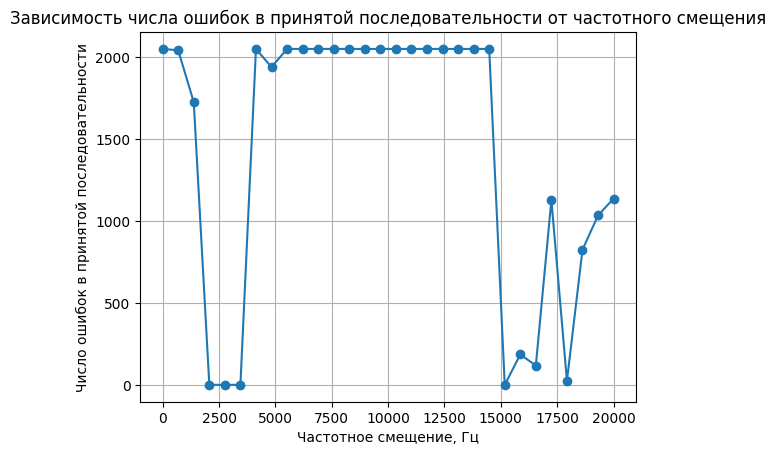

In [102]:
plt.figure()
plt.plot(freq_offset_range, bit_errors_freq, '-o')
plt.title('Зависимость числа ошибок в принятой последовательности от частотного смещения')
plt.ylabel('Число ошибок в принятой последовательности')
plt.xlabel('Частотное смещение, Гц')
plt.grid()

### 20. Зависимость от временного сдвига  
Готовая система была исследована на зависимость от временного сдвига. В качестве результатов построен график зависимости числа ошибок в принятой последовательности от величины временного смещения. Разработанная система корректно работает до значений временного сдвига 40 тактов.

In [103]:
def test_time(snr, freq_offset_value, phase_offset_value, delay_range):
    bit_errors = np.zeros_like(delay_range)
    for iter_delay, delay in enumerate(delay_range):
        data = []  
        for i in range(data_len):
            data.append(random.randint(0, order-1)) 

        data_mod = modem.modulate(data) 
        data_tx = np.hstack([pream, data_mod])
        upsampled = np.zeros(len(data_tx) * sps, dtype=complex)
        upsampled[0::sps] = data_tx 
        
        tx = np.convolve(upsampled, h_rrc)
        data_mod_offset = freq_offset(tx, freq_offset_value, fs)
        data_mod_phaseof = phase_offset_func(data_mod_offset, phase_offset_value)
        awgn_noise = awgn(data_mod_phaseof, snr)
        tx = data_mod_phaseof + awgn_noise
        
        N = delay*2
        n = np.arange(-N//2, N//2)
        h = np.sinc(n)
        h *= np.hamming(N) 
        h /= np.sum(h) 

        tx_shift = np.convolve(tx, h) 
        rx_ = np.convolve(tx_shift, h_rrc)/sps
        
        rx = rx_[(num_tups-1):-(num_tups-1)]
        rx_time_sync = syncMM(rx, sps)
        
        freq_offset_estimation = freq_estimation(rx_time_sync, sps, 4)
        rx_freq_sync = freq_offset(rx_time_sync, -1*freq_offset_estimation, fs/sps)

        sync_data = Costas_Loop(rx_freq_sync, alpha = 0.05, beta = 0.001)
        
        correlation = np.abs(np.correlate(np.real(sync_data), np.real(pream), mode='full')/len(pream))
        position_correlation_max = np.argmax(correlation)
        position_start = position_correlation_max + 1 - len(pream)
        
        hard_decisions = qpsk_demod(sync_data[position_correlation_max + 1:])
        size_min = np.minimum(len(hard_decisions), len(data_mod))
        bit_errors[iter_delay] = np.sum(hard_decisions[:size_min] != data_mod[:size_min])
    
    return bit_errors

snr = 30
freq_offset_value = 2.5e3
phase_offset_value = np.pi/8
delay_range = np.arange(1, 100, 5)

bit_errors_time =  test_time(snr, freq_offset_value, phase_offset_value, delay_range)

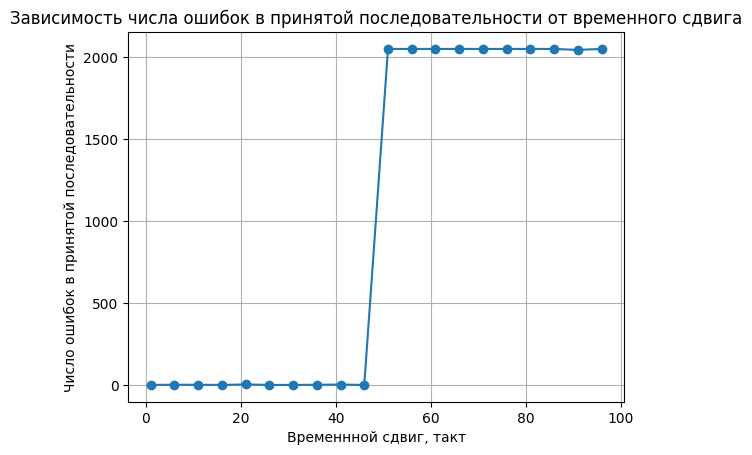

In [104]:
plt.figure()
plt.plot(delay_range, bit_errors_time, '-o')
plt.title('Зависимость числа ошибок в принятой последовательности от временного сдвига')
plt.ylabel('Число ошибок в принятой последовательности')
plt.xlabel('Временнной сдвиг, такт')
plt.grid()

## Вывод  
В результате выполнения лабораторной работы реализованна приемопередающая система, состоящая из модулятора/демодулятора QPSK; блока добавления преамбулы; формирующего и согласованного фильтров корня из приподнятого косинуса; блоков тактовой, частотной (грубой и точной), фазовой, кадровой синхронизаций. В качестве воздействий на систему реализованы частотный, фазовый сдвиги, задержка и АБГШ.  
Полученная система была исследована на зависимость количества ошибок на выходе схемы от вида воздействия.   
В результате исследования на зависимость от АБГШ сделан вывод, что с увеличением отношения сигнал/шум число ошибок уменьшается, однако в результатах может присутствовать выброс, связанный со случайной некорректной работой одной из синхронизаций.  
Исследование зависимости от фазового сдвига показывает, что при повороте более чем на 45 градусов, петля Костаса доворачивает созвездие в неправильном направлении, что влечет за собой неверную демодуляцию.   
Исследование зависимости от частотного сдвига показало, что разработанная система работает корректно в диапазоне частотных смещений от 2000 до 3500 Гц.   
Исследование зависимости от временного сдвига показало, что разработанная система корректно работает до значений временного сдвига 40 тактов.